# Signal analysis assignment 3
## Duty 1
by Øystein Hiåsen (hiasen@stud.ntnu.no)

In [2]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# First we read in the wav-file.
fysikk_file = "fysikk.wav"
fs, sound = wavfile.read(fysikk_file)

# time to sample conversion function
t2s = lambda x: x*fs

# Then we determine how long the sound-file is in seconds:
sound_length = len(sound)/fs

# And create the corresponding time vector
time = np.linspace(0, sound_length, len(sound))

Now we look at a plot of the sound-file. To get a rough idea of how i looks.

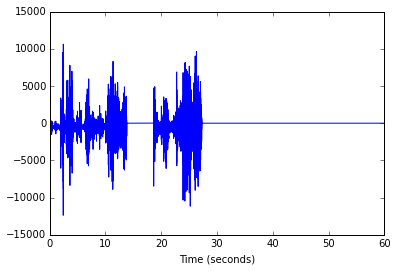

In [4]:
plt.plot(time, sound)
plt.xlabel("Time (seconds)")

It looks like there is no sound after approximatly 28-29 seconds. So lets remove all the samples that are zero at the end of the clip.

In [5]:
last_nonzero_sample = np.nonzero(sound)[0][-1]
my_slice = slice(last_nonzero_sample)

And plot again

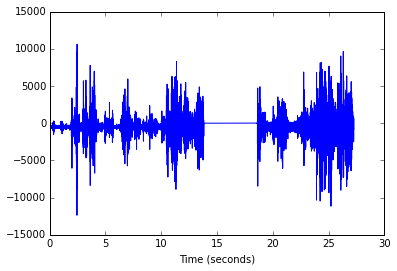

In [6]:
plt.plot(time[my_slice], sound[my_slice])
plt.xlabel("Time (seconds)")

This looks better.

It also looks like (and sounds like) there are actually two distinct clips in this sound clip.
So lets split them up into two arrays, the part that is before 15 seconds and the part after.

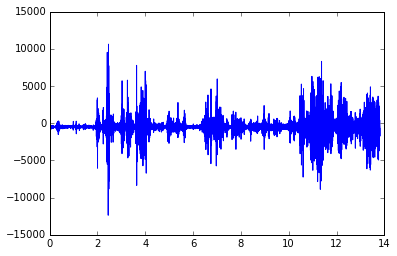

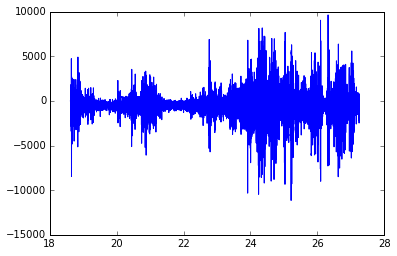

In [10]:
somewhere_between_the_two_parts = t2s(15)

last_index_part1 = np.nonzero(
    sound[:somewhere_between_the_two_parts]
)[0][-1]
first_index_part2 = somewhere_between_the_two_parts + np.nonzero(
    sound[somewhere_between_the_two_parts:]
)[0][0]


clip1 = slice(0, last_index_part1 + 1)
clip2 = slice(first_index_part2, last_nonzero_sample+1)

plt.plot(time[clip1], sound[clip1])
plt.figure()
plt.plot(time[clip2], sound[clip2])

Now we can also look at a spectogram of the first part.

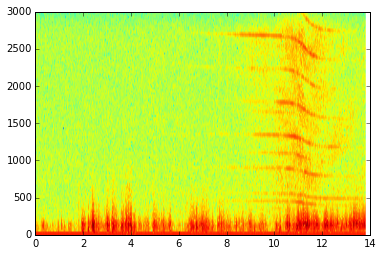

In [143]:
spectrum1, freqs1, time1, img1 = plt.specgram(sound[clip1], Fs=fs)

Here we can clearly see some distinct frequency-lines. Between the times 10 seconds and 12 seconds the frequencies seem to shift down  somewhat constant again.

##Physical model for the spectral content

The doppler shift is given by the equation

$$ f = \frac{c + v_r}{c+v_s} f_0$$
where $f$ is the observed frequency,
$f_0$ is the actually emitted frequency,
$c$ is the speed of sound,
$v_r$ is the speed of the observer and
$v_s$ is the speed of the source.

In our case the observer is stationary, so $v_r = 0$, so the observed frequency is just
$$ f = \frac{c}{c+v_s} f_0 = \frac{f_0}{1+\frac{v_s}{c}} .$$


We assume the passing car is moving at a constant speed $v$ in a straight line where the closest distance  between the car and the observer is $d$.
A drawing of the situation can be seen below.

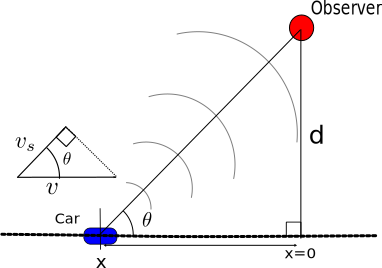

In [41]:
from IPython.display import SVG, display_svg
display_svg(SVG("doppler_car.svg"))

From the above figure we can see that the speed at which the car is moving towards the observer is 
$$v_s = v \cos\theta = v \frac{x}{\sqrt{x^2 + d^2}} = \frac{v}{\sqrt{1 + (\frac{d}{x})^2}}  .$$

$$x = v\cdot(t-t_0)$$
Where $t_0$ is the time when the car is closest to the observer.

Putting it all together we get

$$ f = \frac{f_0}{1 +\frac{v/c}{\sqrt{1 + \left(\frac{d}{v(t-t_0)}\right)^2}}} = \frac{f_0}{1 +\frac{v^2(t-t_0)/c}{\sqrt{{v(t-t_0)}^2 + d^2}}}$$

Looking at this formula we can see that when $t=t_0$ we get $f=f_0$.

Lets now try to plot this frequency-shift as a function of time for different parameters of

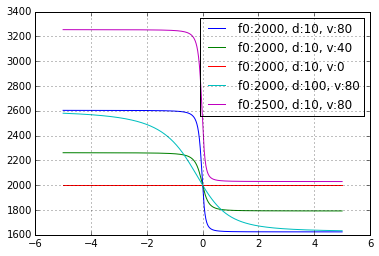

In [68]:
def plot_frequency(f0, t, t0, v, d, label_format="f0:{f0}, d:{d}, v:{v}"):
    c = 345
    x = v * (t - t0)
    vs = v * x / np.sqrt(d**2 + x**2)
    f = f0/(1 + vs/c)
    plt.plot(t, f, label=label_format.format(**locals()))
plot_frequency(2000, np.linspace(-5, 5, 1000), 0, v=80, d=10)
plot_frequency(2000, np.linspace(-5, 5, 1000), 0, v=40, d=10)
plot_frequency(2000, np.linspace(-5, 5, 1000), 0, v=0, d=10)
plot_frequency(2000, np.linspace(-5, 5, 1000), 0, v=80, d=100)
plot_frequency(2500, np.linspace(-5, 5, 1000), 0, v=80, d=10)

plt.legend()
plt.grid()

These plots seem similar lines in the spectrograms calculated earlier.

In the plot above we can see that the speed $v$ affect the amount the frequency is shifted and the distance $d$ affect how much time it takes before the frequency is shifted.


## Applying the model to the spectrogram

We make a smaller window of the spectrogram to try to fit the model to the spectrogram data.

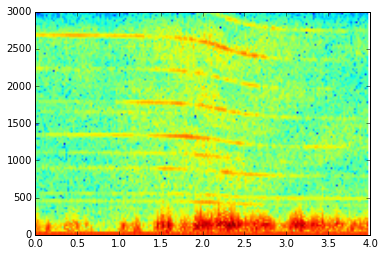

In [72]:
smaller_window = slice(t2s(9), t2s(13))
spectrum, freqs, spec_time, img = plt.specgram(sound[smaller_window], Fs=fs)

To fit the frequency  we need to figure out when the car has passed, that is determine the time $t_0$.
A good guess is $t_0 = 2.3 \ \mathrm{seconds}$.

Now we plot the spectrum at the $t_0$ and the spectogram with a vertical line at $t_0$.

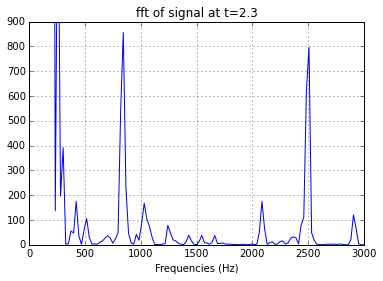

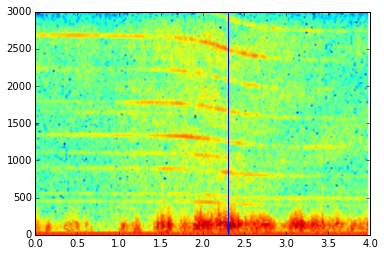

In [120]:
t0 = 2.30
sample_t0 = t0*len(spec_time)/spec_time[-1]
plt.plot(freqs[:], spectrum[:, sample_t0])
plt.ylim([0, 900])
plt.title("fft of signal at t={}".format(t0))
plt.grid()
plt.xlabel("Frequencies (Hz)")

plt.figure()
# Plotting the spectrogram again
_ = plt.specgram(sound[smaller_window], Fs=fs)
# plot a vertical line showing when the car passes
plt.plot([t0, t0], [0, 3000])

Using the above plot we can determine the original frequencies $f_0$ emitted by the car.

In [113]:
# The real frequencies emmited by the car found by looking at the 
# two above plots
# in Hertz
frequencies = [2500,
               2080,
               1670,
               1250,
               520,
               450,
               1030,
               840,
               2920
              ]

Now we can use a "trail and error"-method to fit the parameters in the model to the above spectrogram.

Distance: 10 m
Speed: 24 m/s (86.4 km/h)


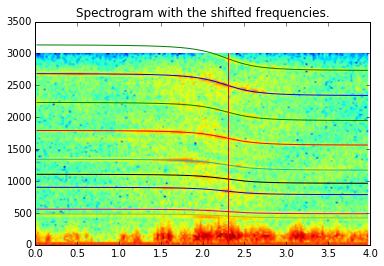

In [127]:
# Plotting the spectrogram again
spectrum, freqs, spec_time, img = plt.specgram(sound[smaller_window], Fs=fs)

# Parameters found by trial and error
v = 24 # m/s
d = 10 # meters

# Plot all the frequencies-shifts in the spectrogram
for freq in frequencies:
    plot_frequency(freq, spec_time, t0, v, d)

# plot a vertical line showing when the car passes
plt.plot([t0, t0], [0, 3000])
plt.title("Spectrogram with the shifted frequencies.")
print("Distance: {} m".format(d))
print("Speed: {} m/s ({} km/h)".format(v, v*3.6))

## Conclusion 
A speed of 24 m/s (86 km/h) and a distance of 10 meters seem to fit well.